## LASSO Regression

This notebook was adapted from: <br>
Wilmanski et al. (2019). [Blood metabolome predicts gut microbiome alpha-diversity in humans](https://www.nature.com/articles/s41587-019-0233-9#Sec24). Nature biotechnology 37, 1217–1228. <br>
Available at [https://github.com/PriceLab/ShannonMets](https://github.com/PriceLab/ShannonMets)

load libraries

In [1]:
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
from string import ascii_letters
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

load feature table

In [3]:
discovery_mets=pd.DataFrame.from_csv('../../featuretable_blankfiltered.tsv', sep = '\t')
discovery_mets.index=discovery_mets.index.astype('float64')
print (discovery_mets.shape)

(6053, 148)


In [4]:
discovery_mets = discovery_mets.T

In [5]:
discovery_mets = discovery_mets.iloc[2:]

load metadata

In [7]:
md = pd.DataFrame.from_csv('../../metadata.tsv', sep = '\t')

In [9]:
md = md.reindex(index=discovery_mets.index)
md = md.reset_index()

# Discovery Cohort Analysis

(146, 6053)
AxesSubplot(0.125,0.125;0.775x0.755)


(array([20.,  8., 20., 10., 10., 20., 10., 19., 10., 19.]),
 array([28. , 29.4, 30.8, 32.2, 33.6, 35. , 36.4, 37.8, 39.2, 40.6, 42. ]),
 <a list of 10 Patch objects>)

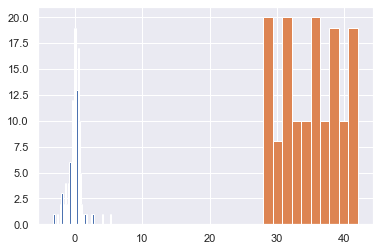

In [11]:
#Scale and standardize metabolites
X = discovery_mets
y = (md['ATTRIBUTE_Gestationsalder'])
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=X.columns
X = scaler.fit_transform(X)
X=pd.DataFrame(data=X,columns=Xcolumns)
print (X.shape)
sns.set(font_scale=1.00)
#test scaling
print (X[1].hist(bins=50))
#plot histogram of outcome variable shannon
plt.hist(y)

In [12]:
## run cross_val_score on ridge and lasso to get out-of-sample R2 scores across 10-CV
#defining L2 parameters to be tested
alphas = np.linspace(1,1000,200)
#Defining LASSO and Ridge parameters
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
ridgecv=RidgeCV(alphas=alphas,fit_intercept=True,normalize=False,cv=10)
#Running 10-fold CV score function to get mean out-of-sample R2
discovery_score=cross_val_score(lassocv,X,y,cv=10)
print ('mean out-of-sample R2 LASSO',np.mean(discovery_score))
discovery_score_ridge=cross_val_score(ridgecv,X,y,cv=10)
print ('mean out-of-sample R2 Ridge',np.mean(discovery_score_ridge))

mean out-of-sample R2 LASSO 0.3700790343889124
mean out-of-sample R2 Ridge 0.2113099148754541


In [13]:
#Run Cross-validation and extract Beta_coefficients for each model
#Save predictions from each test set
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)

In [14]:
y = (md['ATTRIBUTE_Gestationsalder'])

In [15]:
X_folds = np.array_split(X, 10)
y_folds = np.array_split(y, 10)
coefficients=pd.DataFrame(index=X.columns).astype('float64')
predictions=[]
alphas= []
score= []

In [16]:
for k in range(10):
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_train = np.concatenate(y_train)
    lassocv.fit(X_train, y_train)
    predictions.append(list(lassocv.predict(X_test).flatten()))
    coef=list(lassocv.coef_)
    coefficients[k]=coef
    alphas.append(lassocv.alpha_)
    score.append(r2_score(y_test,lassocv.predict(X_test)))
#The L1 penalty for each model
print (alphas)
predictions_lasso=[item for sublist in predictions for item in sublist]
#Checking r2 score and pearson r
print ('mean R2 Score LASSO',np.mean(score))
print ('std. deviation for R2 Score',np.std(score))
print ('S.E.M',np.std(score)/np.sqrt(10))
print ('observed v predicted pearson r',stats.pearsonr(md['ATTRIBUTE_Gestationsalder'],predictions_lasso))

[0.5486379863340465, 0.5110016555585606, 0.5031720871309509, 0.5013677198985887, 0.48804948104402107, 0.4770473973640907, 0.4562092011452418, 0.4716448860879492, 0.4617743805023959, 0.4244862904952434]
mean R2 Score LASSO 0.3700790343889124
std. deviation for R2 Score 0.42488071381123693
S.E.M 0.1343590789521669
observed v predicted pearson r (0.6980930801445488, 1.21088857429837e-22)


In [17]:
score

[-0.6851461933585019,
 0.0019748748076549028,
 0.3646628182176739,
 0.7291385616261414,
 0.5596466483233318,
 0.6278175836245387,
 0.7438514237686602,
 0.4203439295290381,
 0.18375527104795875,
 0.7547454263026275]

In [18]:
predictions=pd.DataFrame(index=discovery_mets.index)
predictions['predictions']=predictions_lasso
predictions['shannon']= md['ATTRIBUTE_Gestationsalder']
predictions.to_csv("predictions.csv")

### Plot metabolome predicted gestational age versus observed gestational age

In [19]:
color = [str(item/255) for item in md['ATTRIBUTE_Gestationsalder']]

In [20]:
from matplotlib import cm

In [21]:
len(md['ATTRIBUTE_Gestationsalder'])

146

In [22]:
cols = cm.viridis(md['ATTRIBUTE_Gestationsalder'])

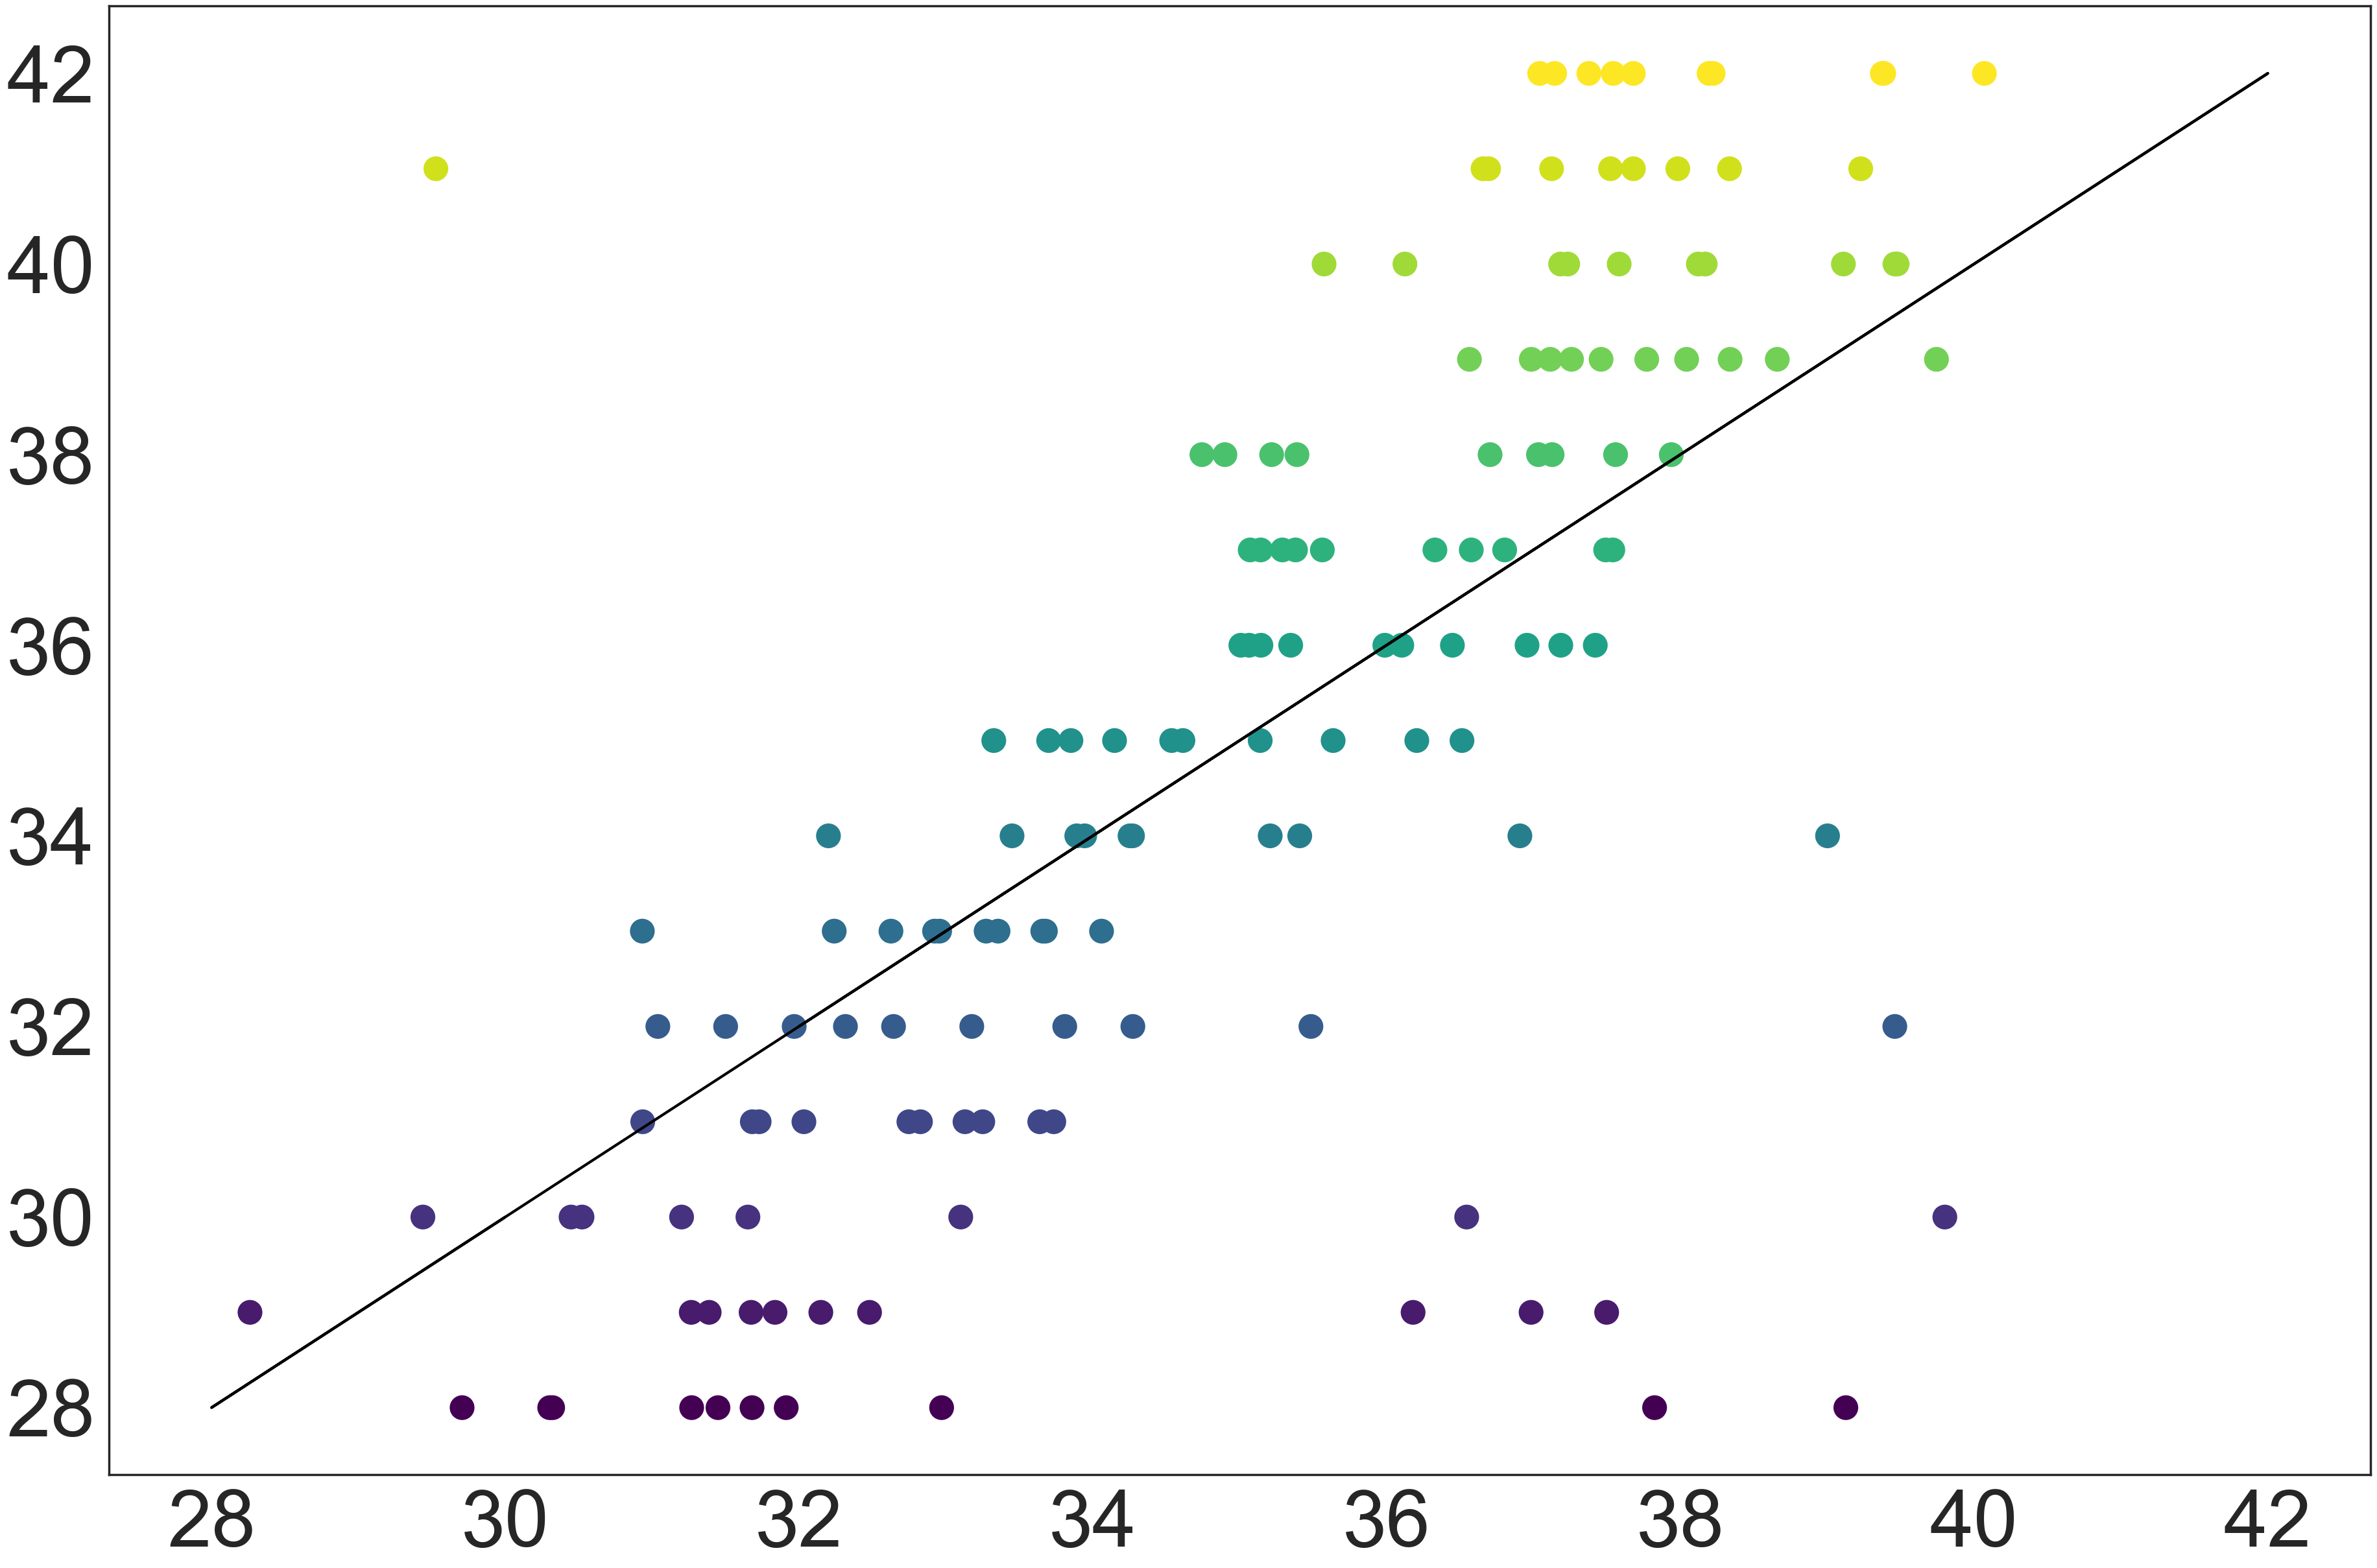

In [23]:
sns.set(font_scale=4.00,context='poster',font='Arial', style='white') 
plt.figure(figsize=[45,30], dpi=100)
plt.scatter(predictions_lasso, md['ATTRIBUTE_Gestationsalder'],s=600,alpha=1,linewidth=3, c=md['ATTRIBUTE_Gestationsalder'], cmap='viridis') #color='#440154FF', edgecolors='#440154FF'
plt.plot(y,y,color='black')
plt.savefig('PredictedVsObserved.pdf')

In [26]:
#Identifying all metabolites with non-zero Beta Coefficients 
for x in coefficients.index.tolist():
    if (coefficients.loc[x] == 0.0).sum()==10:
        coefficients.drop([x],inplace=True)
print (coefficients.shape)
#calculating mean beta-coefficient for each metabolite and counting no. of times each metabolite had a 0 beta-coefficient.
means=[]
std=[]
zeroes=[]
for x in coefficients.index.tolist():
    means.append((np.mean(coefficients.loc[x])))
    std.append((np.std(coefficients.loc[x])))
    zeroes.append((coefficients.loc[x] == 0.0).astype(int).sum())
coefficients['mean']=means
coefficients['std_dev']=std
coefficients['zeroes']=zeroes
#save table as csv
coefficients.to_csv('LASSO_coefs.csv')

(93, 13)


# Assessing collinearity

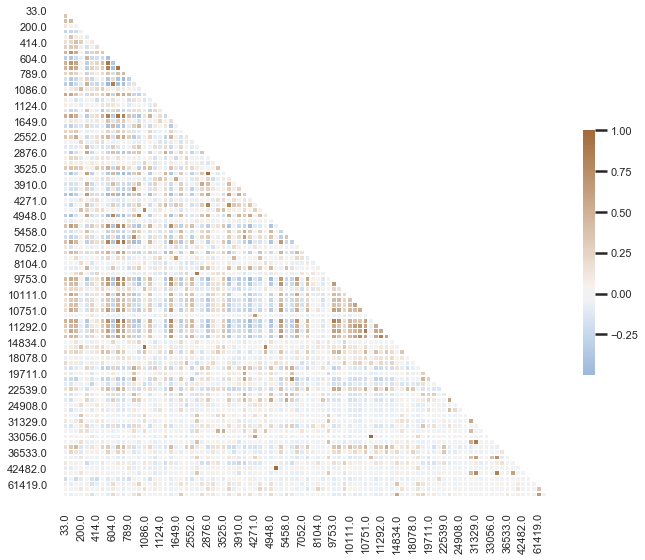

In [27]:
#Select only the 40 identified mets for correlation
corr_df=pd.DataFrame(index=discovery_mets.index)
for x in coefficients.index.tolist():
    corr_df[x]=discovery_mets[x]
#Change metabolite names to just the name (no family, subfamily)
# Compute the correlation matrix
corr = corr_df.corr('pearson')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(font_scale=0.50,context='poster',font='Arial',style='white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 40, as_cmap=True)
heatmap=sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap
plt.savefig('heatmap_40_.png',dpi=200)

In [28]:
#no. of corellations >0.80
r=corr.values.flatten()
#remove corelations of metabolites with themselves (r=1)
print (len(r))
r = [x for x in r if x !=1]
print (len(r))
#count number of correlations where absolute value of r>0.80
print (len([i for i in r if abs(i)>0.80]))

8649
8556
52


In [29]:
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
corr_df=pd.DataFrame()
for x in coefficients.index.tolist():
    corr_df[x]=X[x]
corr_df
corr_df=corr_df.corr(method='pearson', min_periods=1)
#corr_df.replace(to_replace=1, value=0, inplace=True, limit=None, regex=False, method='pad')
r=corr_df.values.flatten()
r = [x for x in r if x !=1]
j=[]
j = [i for i in r if i>0.80]
print (len(j))
print (len(r))

52
8556


(array([  28.,   58.,   78.,  138.,  164.,  276.,  374.,  522., 1224.,
        1648.,  962.,  684.,  496.,  406.,  288.,  198.,  208.,  188.,
         158.,   98.,   96.,   78.,   56.,   32.,   28.,   18.,   30.,
          10.,    8.,    4.]),
 array([-0.49686037, -0.44696503, -0.39706968, -0.34717434, -0.29727899,
        -0.24738364, -0.1974883 , -0.14759295, -0.09769761, -0.04780226,
         0.00209308,  0.05198843,  0.10188378,  0.15177912,  0.20167447,
         0.25156981,  0.30146516,  0.3513605 ,  0.40125585,  0.4511512 ,
         0.50104654,  0.55094189,  0.60083723,  0.65073258,  0.70062793,
         0.75052327,  0.80041862,  0.85031396,  0.90020931,  0.95010465,
         1.        ]),
 <a list of 30 Patch objects>)

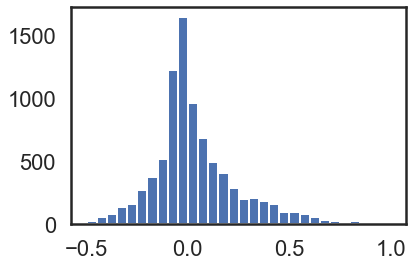

In [30]:
plt.hist(r,bins=30)